# Imports

In [1]:
import pickle
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import scipy

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, AveragePooling1D, Dropout, Flatten, Concatenate, Input, BatchNormalization, LSTM, Add, Reshape

import warnings
warnings.filterwarnings("ignore")

2024-08-25 06:04:32.834163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-25 06:04:32.834946: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 06:04:32.837530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 06:04:32.844917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 06:04:32.856701: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
SEED_VALUE = 42

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# Loading Data

In [3]:
with open("dataset/data.pickle", "rb") as handler:
  data = pickle.load(handler)

# Preparing Data

In [4]:
def interpolate (x, y, rooting = False):
    if rooting:
        return scipy.interpolate.UnivariateSpline(x, y, k = 5, s = 0)
    else:
        return scipy.interpolate.PPoly.from_spline(
            scipy.interpolate.splrep(x, y, k = 5, s = 0)
        )

In [5]:
def scale_signal (signal, mode = "minmax"):
    if mode == "minmax":
        return (np.array(signal) - np.min(signal)) / (np.max(signal) - np.min(signal))
    elif mode == "standard":
        return (np.array(signal) - np.mean(signal)) / np.std(signal)
    else:
        return None

In [6]:
x = data[:, :-3]
s = data[:, -3]
y = data[:, -1]

In [7]:
S = []
for i in tqdm(range(len(s))):
    signal = s[i]
    
    x_axis = np.linspace(0, signal.shape[0] - 1, 1250)
    signal_spline = interpolate(np.arange(signal.shape[0]), signal)
    inter_signal = signal_spline(x_axis)
    inter_signal = scale_signal(inter_signal)
    
    d1_spline = signal_spline.derivative(1)
    d1_signal = d1_spline(x_axis)
    d1_signal = scale_signal(d1_signal)
    
    ft = np.abs(scipy.fft.fft(signal))
    ft_spline = interpolate(np.arange(ft.shape[0]), ft)
    ft_signal = ft_spline(x_axis)
    ft_signal = scale_signal(ft_signal)

    input = np.asarray([inter_signal, d1_signal])
    input = np.moveaxis(input, 0, -1)
    
    S.append(input)

s = np.asarray(S)

100%|████████████████████████████████████████| 666/666 [00:01<00:00, 581.24it/s]


In [8]:
s.shape

(666, 1250, 2)

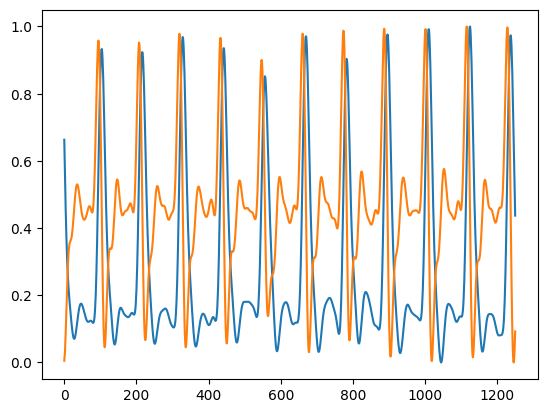

In [9]:
idx = 6
plt.plot(s[idx][:, 0])
plt.plot(s[idx][:, 1])
# plt.plot(s[idx][:, 2])

In [10]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [11]:
# scaler = MinMaxScaler()
# scaler.fit(S)
# S = scaler.transform(S)

In [12]:
y = np.asarray(y, dtype = np.float32)

In [13]:
x_train, x_test, S_train, S_test, y_train, y_test = train_test_split(
    x, s, y,
    test_size = 0.2,
    shuffle = True,
    random_state = 1
)

# Evaluation Functions

In [14]:
def evaluation_metrics (y_test, y_pred, plot = True):
    y_pred = y_pred.flatten()
    metrics = {
        "STD": np.std(y_pred - y_test),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared = False),
        "R2": r2_score(y_test, y_pred)
    }
    if plot:
        for key, value in metrics.items():
            print(key, value, sep = "\t")
    return metrics

In [15]:
def plot_tests (y_test, y_pred):
    y_pred = y_pred.flatten()
    
    plt.figure()
    # plt.scatter(list(range(len(y_test))), y_test, alpha = 0.5)
    # plt.scatter(list(range(len(y_pred))), y_pred, alpha = 0.5)
    plt.plot(y_test, label = "Real")
    plt.plot(y_pred, label = "Prediction")
    plt.show()
    
    plt.figure()
    plt.bar(list(range(len(y_test))), np.abs(y_test - y_pred))
    plt.show()

    plt.figure()
    plt.hist(y_pred.flatten() - y_test, bins = 100)
    plt.show()
    
    plt.figure()
    plt.hist(np.abs(y_pred.flatten() - y_test), bins = 100)
    plt.show()

In [16]:
def standards_stats (y_test, y_pred, threshold):
    y_pred = y_pred.flatten()
    return np.sum(np.abs(y_test - y_pred.flatten()) <= threshold) / len(y_test)

# Model Definition

https://github.com/HealthSciTech/Robust_PPG_PD/blob/master/PPG_peak_detection.py
https://www.mdpi.com/2075-4418/13/15/2566

In [24]:
def cnn_model():

    # model = Sequential()

    # #------------------------------------
    # # Conv Block 1: 32 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=input_shape))
    # model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Conv Block 2: 64 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Conv Block 3: 64 Filters, MaxPool.
    # #------------------------------------
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    # model.add(MaxPooling1D(pool_size=2))

    # #------------------------------------
    # # Flatten the convolutional features.
    # #------------------------------------
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dense(1, activation='relu'))

    # return model

    in1 = Input(shape = (1250, 2))
    in2 = Input(shape = (5, 1))

    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", padding='same')(in1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=5, filters=16, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=7, filters=16, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=9, filters=64, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(kernel_size=9, filters=64, activation="elu", padding='same')(x1)
    # x1 = Dropout(0.1)(x1)
    
    # x1 = Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=2, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=4, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)
    # x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=2)(x1)

    ####
    # x1 = Conv1D(filters=32, kernel_size=2, activation="relu", padding='same')(in1)
    # x1 = AveragePooling1D(pool_size=4, strides=4)(x1)
    # x1 = Conv1D(filters=64, kernel_size=4, activation="relu", padding='same')(x1)
    # x1 = AveragePooling1D(pool_size=4, strides=2)(x1)
    # x1 = Conv1D(filters=32, kernel_size=6, activation="relu", padding='same')(x1)
    # x1 = AveragePooling1D(pool_size=4, strides=2)(x1)
    ####


    ##3
    # x1 = Conv1D(filters=8, kernel_size=2, activation="relu", padding='same')(in1)
    # x1 = Conv1D(filters=16, kernel_size=4, activation="relu", padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=3, strides=3)(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = Conv1D(filters=32, kernel_size=6, activation="relu", padding='same')(x1)
    # x1 = Conv1D(filters=32, kernel_size=8, strides=2, activation="relu", padding='same')(x1)
    # x1 = Conv1D(filters=64, kernel_size=10, strides=2, activation="relu", padding='same')(x1)
    # x1 = MaxPooling1D(pool_size=4, strides=4)(x1)
    # x1 = Dropout(0.1)(x1)
    ###
    
    
    x1 = Conv1D(kernel_size=3, filters=4, activation="elu", dilation_rate=1, padding='same')(in1)
    x1 = Dropout(0.1)(x1)
    x1 = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=2, padding='same')(x1)
    x1 = Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=4, padding='same')(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same')(x1)
    x1 = Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=16, padding='same')(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=32, padding='same')(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Conv1D(kernel_size=3, filters=1, activation="elu", dilation_rate=64, padding='same')(x1)
    x1 = Dropout(0.1)(x1)
    
    x1 = Flatten()(x1)
    # x1 = Dropout(0.1)(x1)
    # x1 = tf.expand_dims(x1, axis = 2)
    # x1 = LSTM(32)(x1)
    # x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Dense(64, activation='relu')(x1)
    x1 = Dense(1, activation='relu')(x1)
    x3 = x1

    #############
    # x2 = Flatten()(in2)
    # x2 = Dense(128, activation='relu')(x2)
    # x2 = Dropout(0.1)(x2)
    # x2 = Dense(64, activation='relu')(x2)
    # x2 = Dropout(0.1)(x2)
    # x2 = Dense(32, activation='relu')(x2)
    # # x2 = Dense(1, activation='relu')(x2)
    # x3 = Concatenate()([x1, x2])
    # # x3 = Dropout(0.1)(x3)
    # x3 = Dense(32, activation='relu')(x3)
    # x3 = Dense(1, activation='relu')(x3)

    # model = Model(inputs = [in1, in2], outputs = x3)
    model = Model(inputs = [in1, in2], outputs = x3)

    # model = Sequential(
    #     [
    #         Conv1D(kernel_size=3, filters=4, activation="elu", dilation_rate=1, padding='same', input_shape=input_shape),
    #         Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=2, padding='same'),
    #         Conv1D(kernel_size=3, filters=8, activation="elu", dilation_rate=4, padding='same'),
    #         Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=8, padding='same'),
    #         Conv1D(kernel_size=3, filters=16, activation="elu", dilation_rate=16, padding='same'),
    #         Conv1D(kernel_size=3, filters=32, activation="elu", dilation_rate=32, padding='same'),
    #         Conv1D(kernel_size=3, filters=1, activation="elu", dilation_rate=64, padding='same'),
    #         Flatten(),
    #         Concatenate(),
    #         Dense(1, activation='elu')
    #     ]
    # )

    return model

In [25]:
model = cnn_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1250, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1250, 4)   │         28 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1250, 4)   │          0 │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1250, 8)   │        104 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1250, 8)   │        200 │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1250, 8)   │          0 │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1250, 16)  │        400 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1250, 16)  │        784 │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1250, 16)  │          0 │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1250, 32)  │      1,568 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1250, 32)  │          0 │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1250, 1)   │         97 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1250, 1)   │          0 │ conv1d_13[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1250)      │          0 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    160,128 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 171,630 (670.43 KB)

 Trainable params: 171,630 (670.43 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [27]:
%load_ext tensorboard
logdir = "logs/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [28]:
model.compile(optimizer='adam',  loss='mae',  metrics=['mae'])

In [29]:
EPOCHS = 250
BATCH_SIZE = 64

history = model.fit([S_train, x_train],
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tensorboard_callback]
                   )

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 124.5437 - mae: 124.5437 - val_loss: 55.4282 - val_mae: 55.4282
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 41.6585 - mae: 41.6585 - val_loss: 22.3157 - val_mae: 22.3157
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 30.7982 - mae: 30.7982 - val_loss: 23.7792 - val_mae: 23.7792
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 25.4911 - mae: 25.4911 - val_loss: 22.6895 - val_mae: 22.6895
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 26.0842 - mae: 26.0842 - val_loss: 22.0585 - val_mae: 22.0585
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 24.7869 - mae: 24.7869 - val_loss: 22.2230 - val_mae: 22.2230
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 25.6234 - mae: 25.6234 - val_loss: 22.0843 - val_mae: 22.0843
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 25.5769 - mae: 25.5769 - val_loss: 22.0876 - val_mae: 22.0876
Epoch 9/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

In [30]:
# %tensorboard --logdir logs/

In [31]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics]
        metric_name = [metric_name]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, EPOCHS])
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

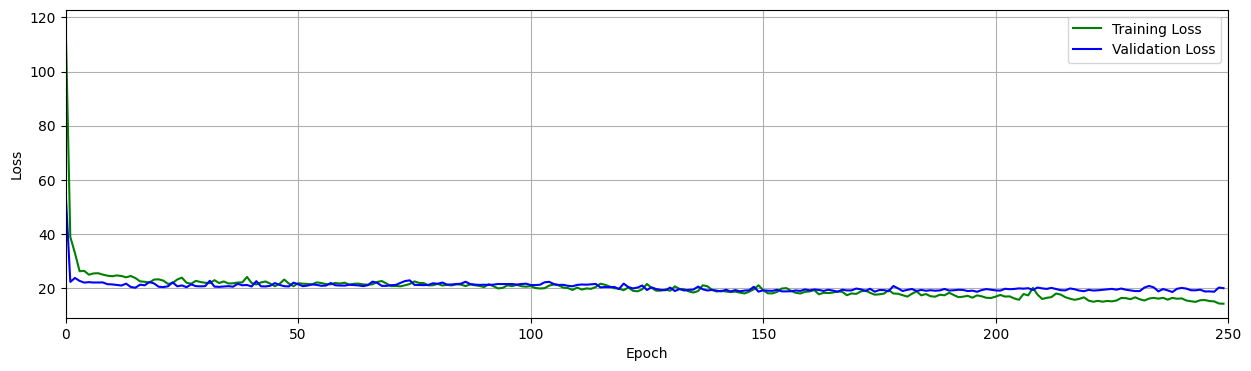

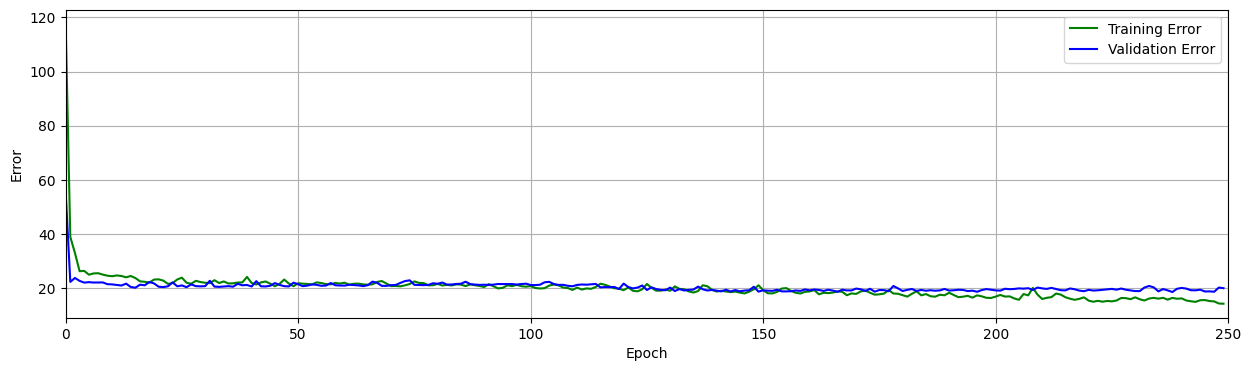

In [32]:
train_loss = history.history["loss"]
train_acc  = history.history["mae"]
valid_loss = history.history["val_loss"]
valid_acc  = history.history["val_mae"]

plot_results([ train_loss, valid_loss ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ],
            ylabel="Error",
            metric_name=["Training Error", "Validation Error"],
            color=["g", "b"])

# Model Test

In [33]:
test_loss, test_acc = model.evaluate([S_test, x_test], y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.5791 - mae: 18.5791


In [34]:
y_pred = model.predict([S_test, x_test])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [35]:
metrics = evaluation_metrics(y_test, y_pred)

STD	22.451553
MAE	17.91374
MSE	521.3058
RMSE	22.83212
R2	0.41158974170684814


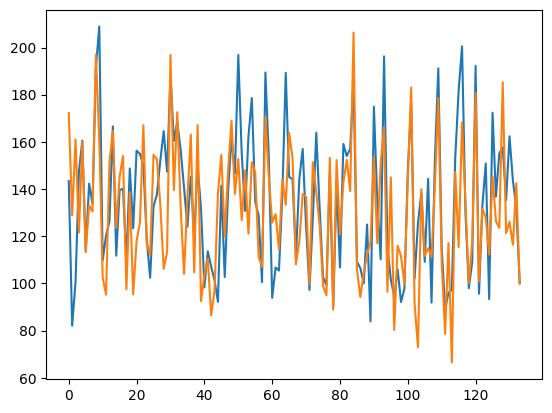

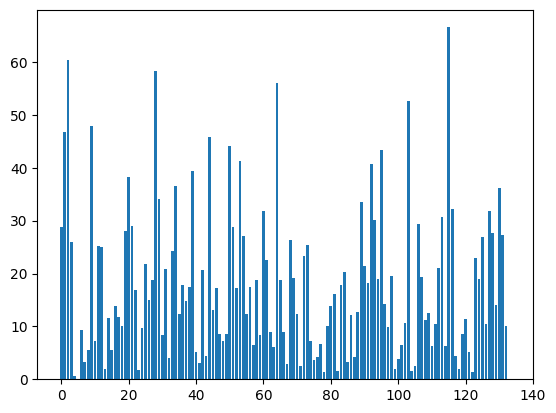

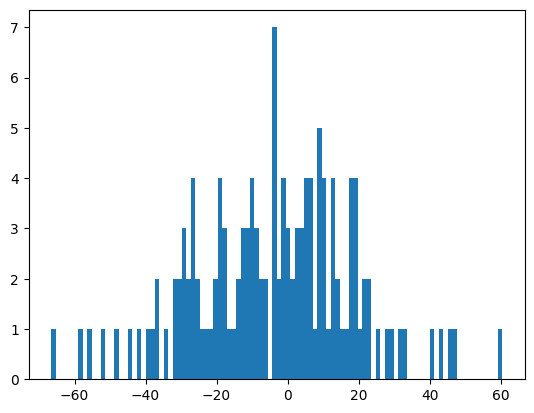

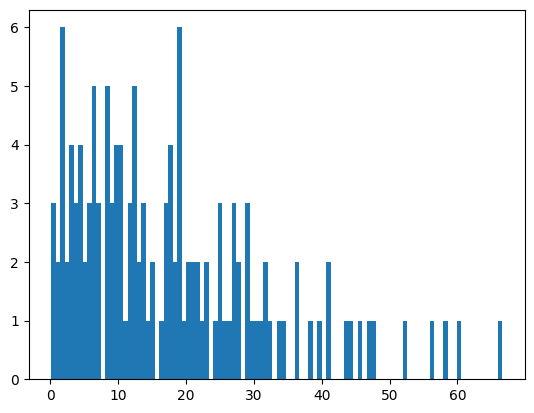

In [36]:
plot_tests(y_test, y_pred)

In [37]:
print("5mmHg", standards_stats(y_test, y_pred, 5), sep = "\t")
print("10mmHg", standards_stats(y_test, y_pred, 10), sep = "\t")
print("15mmHg", standards_stats(y_test, y_pred, 15), sep = "\t")

5mmHg	0.1791044776119403
10mmHg	0.35074626865671643
15mmHg	0.5149253731343284
